In [20]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from patchify import patchify, unpatchify
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
from tensorflow.keras.models import load_model
from scipy.ndimage import label

### Functions for the pipeline:

In [21]:
def f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = TP / (Positives+K.epsilon())
        return recall
    
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = TP / (Pred_Positives+K.epsilon())
        return precision
    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [22]:
def calculate_iou(box1, box2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.
    
    Parameters:
        box1 (tuple): Bounding box 1 (x_min, y_min, x_max, y_max).
        box2 (tuple): Bounding box 2 (x_min, y_min, x_max, y_max).
    
    Returns:
        float: IoU value.
    """
    x_min = max(box1[0], box2[0])
    y_min = max(box1[1], box2[1])
    x_max = min(box1[2], box2[2])
    y_max = min(box1[3], box2[3])

    # Calculate intersection area
    inter_width = max(0, x_max - x_min)
    inter_height = max(0, y_max - y_min)
    inter_area = inter_width * inter_height

    # Calculate area of both bounding boxes
    area_box1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area_box2 = (box2[2] - box2[0]) * (box2[3] - box2[1])

    # Calculate union area
    union_area = area_box1 + area_box2 - inter_area

    # Compute IoU with better precision
    return round(inter_area / union_area, 6) if union_area > 0 else 0

# Example: calculating IoU for two bounding boxes
box1 = (50, 50, 150, 150)
box2 = (100, 100, 200, 200)

iou_value = calculate_iou(box1, box2)
print(f"IoU between the boxes: {iou_value}")


IoU between the boxes: 0.142857


In [42]:
input_path = r"C:\Users\batkm\Documents\Github\2024-25b-fai2-adsai-MichalBatkowski1232079\kaggle challenge\Kaggle Dataset"
output_path = r"C:\Users\batkm\Documents\Github\2024-25b-fai2-adsai-MichalBatkowski1232079\kaggle challenge\Kaggle Dataset\output.csv"
patch_size = 256
example_file_name = r"C:\Users\batkm\Documents\Github\2024-25b-fai2-adsai-MichalBatkowski1232079\Deliverables\task 5\michal_232079_unet_model_v3_256px.h5"
model = load_model(example_file_name, custom_objects={"f1": f1})

# Define the example image for visualizations
example_id = "10"  # The ID of the image you want visualized (e.g., "test_image_1.png" -> ID = "1")


---

### Cropping the images

Processed: test_image_1.png | Cropped Shape: (2707, 2707)
Processed: test_image_10.png | Cropped Shape: (2778, 2778)
Processed: test_image_11.png | Cropped Shape: (2776, 2776)
Processed: test_image_12.png | Cropped Shape: (2788, 2788)
Processed: test_image_13.png | Cropped Shape: (2927, 2927)
Processed: test_image_14.png | Cropped Shape: (2785, 2785)
Processed: test_image_15.png | Cropped Shape: (2787, 2787)
Processed: test_image_16.png | Cropped Shape: (2789, 2789)
Processed: test_image_17.png | Cropped Shape: (2788, 2788)
Processed: test_image_18.png | Cropped Shape: (2788, 2788)
Processed: test_image_2.png | Cropped Shape: (2706, 2706)
Processed: test_image_3.png | Cropped Shape: (2706, 2706)
Processed: test_image_4.png | Cropped Shape: (2706, 2706)
Processed: test_image_5.png | Cropped Shape: (2706, 2706)
Processed: test_image_6.png | Cropped Shape: (2705, 2705)
Processed: test_image_7.png | Cropped Shape: (2706, 2706)
Processed: test_image_8.png | Cropped Shape: (2706, 2706)
Proce

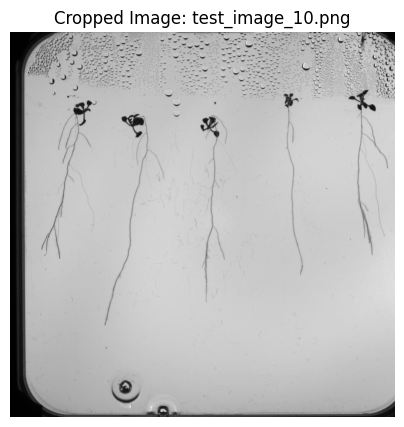

In [24]:
def find_edges(line, threshold=70):
    """
    Finds the left and right edges in a 1D array based on a threshold value.
    """
    left_edge, right_edge = None, None
    n = len(line)
    
    # Loop from the left to find the first transition
    for i in range(1, n):
        if line[i-1] < threshold <= line[i] or line[i-1] >= threshold > line[i]:
            left_edge = i
            break
    
    # Loop from the right to find the last transition
    for i in range(n-1, 0, -1):
        if line[i] < threshold <= line[i-1] or line[i] >= threshold > line[i-1]:
            right_edge = i
            break
    
    return left_edge, right_edge

def format(image, initial_crop=100):
    """
    Crops an image to a square region using edge detection, with an initial horizontal crop.
    """
    # Step 1: Initial horizontal crop
    image = image[:, initial_crop:-initial_crop]  # Crop 100 pixels from left and right

    # Step 2: Horizontal and vertical slices for edge detection
    horizontal_line = image[image.shape[0] // 2, :]  # Middle row of the image
    vertical_line = image[:, image.shape[1] // 2]   # Middle column of the image
    
    # Step 3: Find edges
    left_x, right_x = find_edges(horizontal_line)
    top_y, bottom_y = find_edges(vertical_line)
    
    # Step 4: Ensure the output region is a square
    side_length = max(right_x - left_x, bottom_y - top_y)
    right_x = left_x + side_length
    bottom_y = top_y + side_length
    
    # Step 5: Return slices for cropping
    return slice(top_y, bottom_y), slice(left_x, right_x)

def process_images(input_path, initial_crop=100):
    """
    Processes all images in a folder by cropping them based on detected edges.
    """
    cropped_images = {}  # Dictionary to store cropped images and their slices
    
    for file_name in os.listdir(input_path):
        file_path = os.path.join(input_path, file_name)
        
        # Ensure the file is an image
        if not (file_name.endswith(".png") or file_name.endswith(".jpg") or file_name.endswith(".jpeg")):
            continue
        
        # Load the image
        original_image = cv2.imread(file_path, 0)  # Load as grayscale

        # Crop the image using the format function
        crop_slices = format(original_image, initial_crop=initial_crop)
        cropped_image = original_image[crop_slices]
        
        # Save the cropped image and slices in the dictionary
        cropped_images[file_name] = {
            "cropped_image": cropped_image,
            "crop_slices": crop_slices
        }
        
        print(f"Processed: {file_name} | Cropped Shape: {cropped_image.shape}")
    
    return cropped_images

# Process images and visualize the specified example image
cropped_images = process_images(input_path, initial_crop=90)

# Visualize only the example image
example_file_name = f"test_image_{example_id}.png"  # Match the naming convention
if example_file_name in cropped_images:
    plt.figure(figsize=(5, 5))
    plt.imshow(cropped_images[example_file_name]["cropped_image"], cmap="gray")
    plt.title(f"Cropped Image: {example_file_name}")
    plt.axis("off")
    plt.show()



### Padding the images

Processed test_image_1.png: Original Shape = (2707, 2707), Padded Shape = (2816, 2816), Padding = (Top: 54, Bottom: 55, Left: 54, Right: 55)
Processed test_image_10.png: Original Shape = (2778, 2778), Padded Shape = (2816, 2816), Padding = (Top: 19, Bottom: 19, Left: 19, Right: 19)
Visualizing example image: test_image_10.png


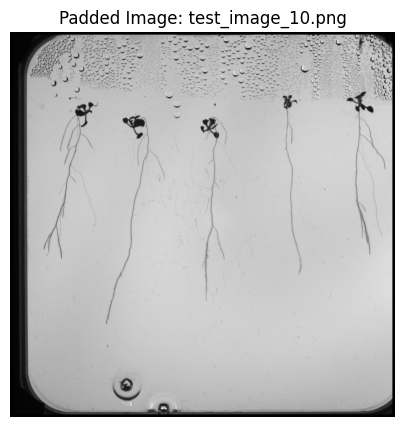

Processed test_image_11.png: Original Shape = (2776, 2776), Padded Shape = (2816, 2816), Padding = (Top: 20, Bottom: 20, Left: 20, Right: 20)
Processed test_image_12.png: Original Shape = (2788, 2788), Padded Shape = (2816, 2816), Padding = (Top: 14, Bottom: 14, Left: 14, Right: 14)
Processed test_image_13.png: Original Shape = (2927, 2927), Padded Shape = (3072, 3072), Padding = (Top: 72, Bottom: 73, Left: 72, Right: 73)
Processed test_image_14.png: Original Shape = (2785, 2785), Padded Shape = (2816, 2816), Padding = (Top: 15, Bottom: 16, Left: 15, Right: 16)
Processed test_image_15.png: Original Shape = (2787, 2787), Padded Shape = (2816, 2816), Padding = (Top: 14, Bottom: 15, Left: 14, Right: 15)
Processed test_image_16.png: Original Shape = (2789, 2789), Padded Shape = (2816, 2816), Padding = (Top: 13, Bottom: 14, Left: 13, Right: 14)
Processed test_image_17.png: Original Shape = (2788, 2788), Padded Shape = (2816, 2816), Padding = (Top: 14, Bottom: 14, Left: 14, Right: 14)
Proces

In [25]:
def padder_from_cropped_images(cropped_images, patch_size, example_id=None):
    """
    Adds padding to all cropped images to make their dimensions divisible by a specified patch size.
    Visualizes results for a specified example image ID.

    Parameters:
        cropped_images (dict): A dictionary with image names as keys and values containing:
            - "cropped_image": The cropped image as a NumPy array.
            - "crop_slices": The crop slices used to crop the original image.
        patch_size (int): The size of the patches the image should be divisible by.
        example_id (str): The ID of the image to visualize results for.

    Returns:
        dict: Updated dictionary with padded images and padding values added.
    """
    padded_images = {}

    for file_name, data in cropped_images.items():
        cropped_image = data["cropped_image"]  # Extract the cropped image

        # Get dimensions of the cropped image
        h, w = cropped_image.shape[:2]
        height_padding = ((h // patch_size) + 1) * patch_size - h
        width_padding = ((w // patch_size) + 1) * patch_size - w

        top_padding = height_padding // 2
        bottom_padding = height_padding - top_padding

        left_padding = width_padding // 2
        right_padding = width_padding - left_padding

        # Add padding using cv2.copyMakeBorder
        padded_image = cv2.copyMakeBorder(
            cropped_image,
            top_padding,
            bottom_padding,
            left_padding,
            right_padding,
            cv2.BORDER_CONSTANT,
            value=[0, 0, 0]  # Padding with black pixels
        )

        # Update the dictionary with the padded image and padding values
        padded_images[file_name] = {
            "padded_image": padded_image,
            "padding": (top_padding, bottom_padding, left_padding, right_padding),
            "crop_slices": data["crop_slices"]  # Retain the original crop slices
        }

        print(f"Processed {file_name}: Original Shape = {cropped_image.shape}, "
              f"Padded Shape = {padded_image.shape}, "
              f"Padding = (Top: {top_padding}, Bottom: {bottom_padding}, "
              f"Left: {left_padding}, Right: {right_padding})")

        # Visualize only if the current file matches the exact example_id
        example_file_name = f"test_image_{example_id}.png"  # Adjust to match your naming convention
        if example_id and file_name == example_file_name:
            print(f"Visualizing example image: {file_name}")
            plt.figure(figsize=(5, 5))
            plt.imshow(padded_image, cmap="gray")
            plt.title(f"Padded Image: {file_name}")
            plt.axis("off")
            plt.show()

    return padded_images

# Run the padding function
padded_images = padder_from_cropped_images(cropped_images, patch_size, example_id)


### Inference:

Processing test_image_1.png...
Completed test_image_1.png: Predicted Mask Shape = (2707, 2707)
Processing test_image_10.png...
Completed test_image_10.png: Predicted Mask Shape = (2778, 2778)
Visualizing example image: test_image_10.png


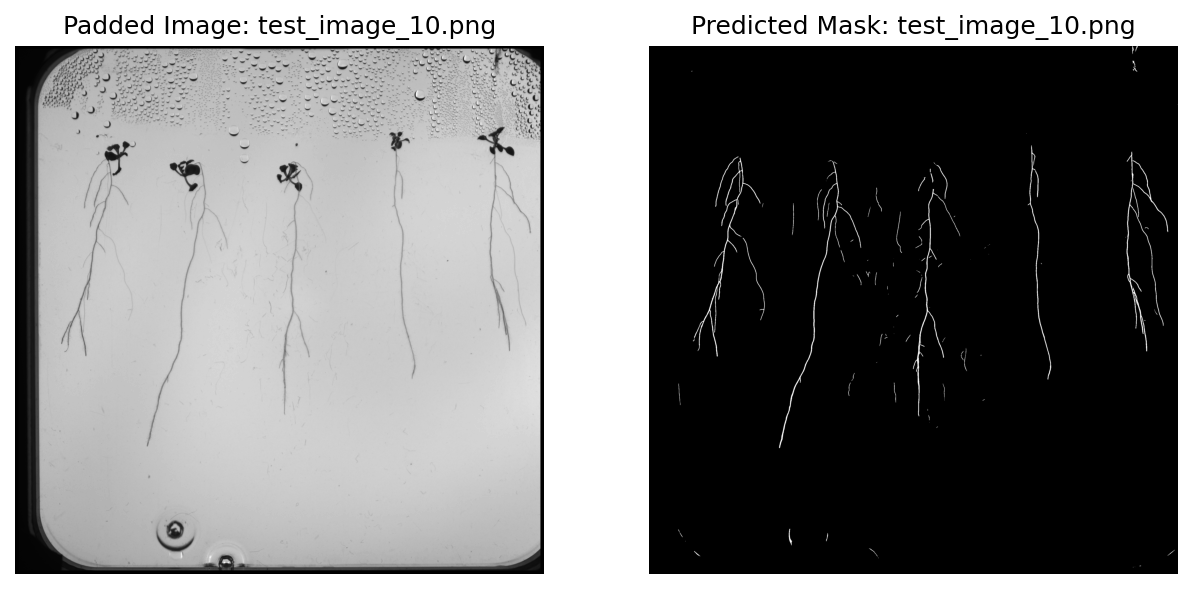

Processing test_image_11.png...
Completed test_image_11.png: Predicted Mask Shape = (2776, 2776)
Processing test_image_12.png...
Completed test_image_12.png: Predicted Mask Shape = (2788, 2788)
Processing test_image_13.png...
Completed test_image_13.png: Predicted Mask Shape = (2927, 2927)
Processing test_image_14.png...
Completed test_image_14.png: Predicted Mask Shape = (2785, 2785)
Processing test_image_15.png...
Completed test_image_15.png: Predicted Mask Shape = (2787, 2787)
Processing test_image_16.png...
Completed test_image_16.png: Predicted Mask Shape = (2789, 2789)
Processing test_image_17.png...
Completed test_image_17.png: Predicted Mask Shape = (2788, 2788)
Processing test_image_18.png...
Completed test_image_18.png: Predicted Mask Shape = (2788, 2788)
Processing test_image_2.png...
Completed test_image_2.png: Predicted Mask Shape = (2706, 2706)
Processing test_image_3.png...
Completed test_image_3.png: Predicted Mask Shape = (2706, 2706)
Processing test_image_4.png...
Com

In [27]:
from patchify import patchify, unpatchify
import numpy as np
import matplotlib.pyplot as plt
import os

def run_inference_on_padded_images(padded_images, model, patch_size, example_id=None):
    """
    Runs inference on multiple padded images, predicts masks, and crops them back to original dimensions.
    Visualizes results for a specified example image ID.

    Parameters:
        padded_images (dict): Dictionary containing padded images and their padding details.
        model (keras.Model): Pre-trained model for inference.
        patch_size (int): Size of patches for prediction.
        example_id (str): The exact ID of the image to visualize results for.

    Returns:
        dict: Dictionary with predicted masks and their original dimensions.
    """
    results = {}

    for file_name, data in padded_images.items():
        print(f"Processing {file_name}...")

        padded_image = data["padded_image"]
        padding = data["padding"]
        top_padding, bottom_padding, left_padding, right_padding = padding

        # Convert to 3 channels for patching
        padded_image_3channel = np.repeat(padded_image[..., np.newaxis], 3, axis=-1)

        # Create patches for prediction
        patches = patchify(padded_image_3channel, (patch_size, patch_size, 3), step=patch_size)
        patches_flat = patches.reshape(-1, patch_size, patch_size, 3) / 255.0  # Normalize

        # Predict patches
        predictions = model.predict(patches_flat, verbose=0)  # Run prediction silently
        predicted_patches = (predictions > 0.5).astype(np.uint8)
        predicted_patches_reshaped = predicted_patches.reshape(
            patches.shape[0], patches.shape[1], patch_size, patch_size
        )

        # Reconstruct the predicted mask
        predicted_mask = unpatchify(predicted_patches_reshaped, padded_image.shape[:2])

        # Remove padding
        predicted_mask_cropped = predicted_mask[
            top_padding:predicted_mask.shape[0] - bottom_padding,
            left_padding:predicted_mask.shape[1] - right_padding
        ]

        # Save the result
        results[file_name] = {
            "predicted_mask": predicted_mask_cropped,
            "original_shape": predicted_mask_cropped.shape
        }

        print(f"Completed {file_name}: Predicted Mask Shape = {predicted_mask_cropped.shape}")

        # Visualize only if the current file matches the exact example_id
        example_file_name = f"test_image_{example_id}.png"  # Adjust to match your naming convention
        if example_id and file_name == example_file_name:
            print(f"Visualizing example image: {file_name}")
            f, ax = plt.subplots(1, 2, dpi=150, figsize=(10, 5))
            ax[0].imshow(padded_image, cmap='gray')
            ax[0].axis('off')
            ax[0].set_title(f'Padded Image: {file_name}')
            ax[1].imshow(predicted_mask_cropped, cmap='gray')
            ax[1].axis('off')
            ax[1].set_title(f'Predicted Mask: {file_name}')
            plt.show()


    return results

# Run inference and visualize the specific example image
predicted_results = run_inference_on_padded_images(padded_images, model, patch_size, example_id)



### Reverse cropping:

In [28]:
def reverse_crop_shift_right_fixed(cropped_images, predicted_results, input_path, example_id=None, initial_crop=100):
    """
    Restores cropped masks to their original uncropped dimensions for all images by shifting the mask right
    while maintaining the original image size. Applies a fixed 100-pixel shift to the mask to the right.

    Parameters:
        cropped_images (dict): Dictionary containing cropped images and their crop slices.
        predicted_results (dict): Dictionary with predicted masks and their original dimensions.
        input_path (str): Path to the directory containing original images.
        example_id (str): The ID of the image to visualize the restored mask for.
        initial_crop (int): The number of pixels initially cropped from both the left and right sides.

    Returns:
        dict: Dictionary with restored masks for each image.
    """
    restored_masks = {}

    for file_name, data in predicted_results.items():
        # Load the original image to get its shape dynamically
        original_image_path = os.path.join(input_path, file_name)
        original_image = cv2.imread(original_image_path, 0)  # Load as grayscale
        original_shape = original_image.shape

        # Get crop slices and predicted mask
        crop_slices = cropped_images[file_name]["crop_slices"]
        predicted_mask = data["predicted_mask"]

        # Adjust the position of the mask by shifting it right by the initial crop value
        top, bottom = crop_slices[0].start, crop_slices[0].stop
        left, right = crop_slices[1].start + initial_crop, crop_slices[1].stop + initial_crop

        # Ensure that the mask is within the bounds of the original image
        left = max(left, 0)
        right = min(right, original_shape[1])

        # Restore the mask to original dimensions
        restored_image = np.zeros(original_shape, dtype=predicted_mask.dtype)
        restored_image[top:bottom, left:right] = predicted_mask

        # Now, shift the mask right by 100 pixels (hardcoded shift)
        shifted_restored_image = np.zeros_like(restored_image)
        shifted_restored_image[:, :-100] = restored_image[:, 100:]  # Shift right by 100 pixels

        # Save the restored mask
        restored_masks[file_name] = shifted_restored_image

        # Visualize only the example image
        if example_id and file_name == f"test_image_{example_id}.png":
            print(f"Visualizing Restored Mask for: {file_name}")
            plt.figure(figsize=(5, 5))
            plt.imshow(shifted_restored_image, cmap='gray')
            plt.axis('off')
            plt.title(f"Restored and Shifted Mask: {file_name}")
            plt.show()

    return restored_masks


Visualizing Restored Mask for: test_image_10.png


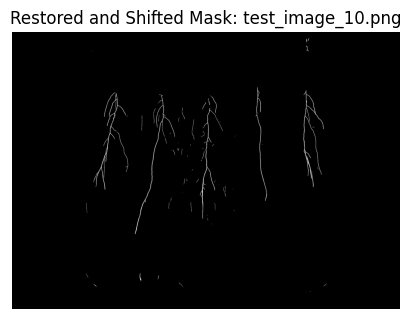

In [29]:
# Restore masks dynamically
restored_masks = reverse_crop_shift_right_fixed(
    cropped_images=cropped_images,
    predicted_results=predicted_results,
    input_path=input_path,
    example_id=example_id,
    initial_crop=100  # Match the initial cropping value
)


##### Overlay for verification:

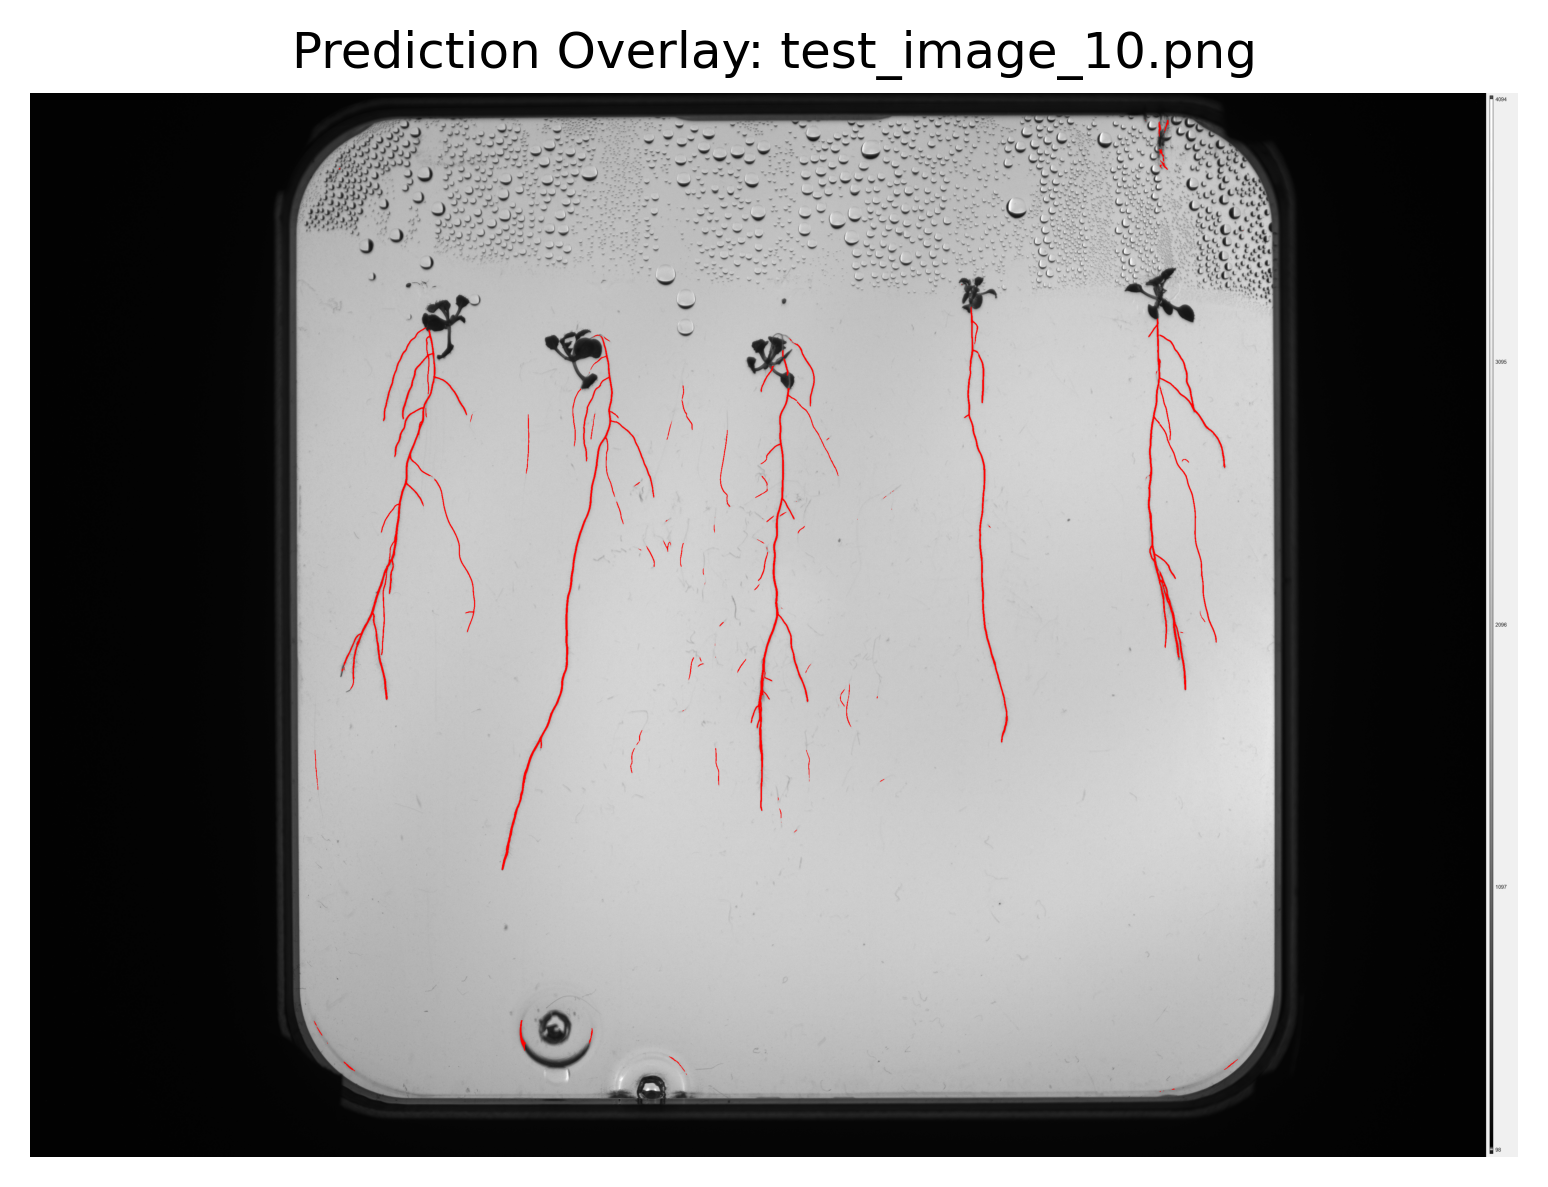

In [30]:
def overlay_restored_image(input_path, restored_masks, example_id=None):
    """
    Creates and visualizes an overlay of the predicted mask on the original uncropped image
    for a specific example ID by accessing images from the input path.

    Parameters:
        input_path (str): Path to the directory containing original images.
        restored_masks (dict): Dictionary containing restored masks.
        example_id (str): ID of the image to visualize the overlay for.

    Returns:
        None
    """
    for file_name, restored_mask in restored_masks.items():
        # Ensure the file matches the example ID
        if example_id and file_name != f"test_image_{example_id}.png":
            continue

        # Load the original image from the input path
        original_image_path = os.path.join(input_path, file_name)
        original_image = cv2.imread(original_image_path, 0)  # Load as grayscale

        # Ensure the restored mask matches the original image dimensions
        assert restored_mask.shape[:2] == original_image.shape[:2], \
            f"Shapes of mask ({restored_mask.shape[:2]}) and image ({original_image.shape[:2]}) do not match!"

        # Convert original image to RGB if it's grayscale
        original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_GRAY2RGB)

        # Create the overlay
        overlay_image = original_image_rgb.copy()
        overlay_image[restored_mask > 0] = [255, 0, 0]  # Red overlay for mask (root pixels)

        # Plot the overlay
        plt.figure(dpi=300)
        plt.imshow(overlay_image)
        plt.axis('off')
        plt.title(f"Prediction Overlay: {file_name}")
        plt.show()
        break  # Visualize only the first matching image

# Visualize the overlay for the example ID
overlay_restored_image(input_path, restored_masks, example_id)


### Morphological operations:

In [31]:
def apply_closing_only(mask, kernel_size):
    """
    Apply morphological closing to fill gaps without removing thin structures.
    
    Parameters:
        mask (np.ndarray): Binary mask.
        kernel_size (tuple): Size of the structuring element.
    
    Returns:
        np.ndarray: Closed mask.
    """
    kernel = np.ones(kernel_size, np.uint8)  # Structuring element
    closed_mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    return closed_mask


In [32]:
from skimage import morphology

def remove_small_objects(mask, size_threshold):
    """
    Remove small connected components below a size threshold.
    
    Parameters:
        mask (np.ndarray): Binary mask.
        size_threshold (int): Minimum size of components to keep.
    
    Returns:
        np.ndarray: Mask with small objects removed.
    """
    filtered_mask = morphology.remove_small_objects(mask > 0, min_size=size_threshold).astype('uint8') * 255
    return filtered_mask


In [33]:
def extract_bounding_boxes_from_stats(stats, min_area=200):
    """
    Extract bounding boxes from connected component stats.
    
    Parameters:
        stats (np.ndarray): Statistics from connected components (x, y, width, height, area).
        min_area (int): Minimum area threshold for valid bounding boxes.
    
    Returns:
        list: List of bounding boxes [(x_min, y_min, x_max, y_max), ...].
    """
    bounding_boxes = []
    for stat in stats[1:]:  # Skip the background (index 0)
        x, y, w, h, area = stat
        if area >= min_area:
            bounding_boxes.append((x, y, x + w, y + h))
    return bounding_boxes


In [34]:
def non_maximum_suppression(bboxes, iou_threshold=0.01, min_y_threshold=700, exclude_top_y=150):
    """
    Apply Non-Maximum Suppression (NMS) to remove overlapping bounding boxes,
    and filter boxes based on y-axis thresholds.
    
    Parameters:
        bboxes (list): List of bounding boxes [(x_min, y_min, x_max, y_max)].
        iou_threshold (float): Threshold for IoU to consider boxes as overlapping.
        min_y_threshold (int): Minimum y_min value for a bounding box to be kept.
        exclude_top_y (int): Exclude boxes with y_min <= this value.
    
    Returns:
        list: Filtered list of bounding boxes after NMS.
    """
    if len(bboxes) == 0:
        return []
    
    # Filter out boxes based on y_min thresholds
    bboxes = [box for box in bboxes if exclude_top_y < box[1] < min_y_threshold]
    
    # Sort by area (descending order)
    bboxes = sorted(bboxes, key=lambda box: (box[2] - box[0]) * (box[3] - box[1]), reverse=True)
    
    # Perform NMS
    filtered_bboxes = []
    while bboxes:
        largest_box = bboxes.pop(0)
        filtered_bboxes.append(largest_box)
        bboxes = [
            box for box in bboxes
            if calculate_iou(largest_box, box) < iou_threshold
        ]
    return filtered_bboxes


### Creating bounding boxes:

In [35]:
def calculate_root_lengths(labeled_mask, original_mask):
    """
    Calculate root lengths for each labeled root in the mask.
    
    Parameters:
        labeled_mask (np.ndarray): Labeled mask with unique IDs for each root.
        original_mask (np.ndarray): Original binary mask of the roots.
    
    Returns:
        dict: Dictionary of root IDs and their calculated lengths.
    """
    from skimage.morphology import skeletonize
    from skan.csr import skeleton_to_csgraph
    import networkx as nx

    skeleton = skeletonize(labeled_mask > 0)
    root_lengths = {}

    for root_id in np.unique(labeled_mask):
        if root_id == 0:  # Skip background
            continue
        
        root_skeleton = (labeled_mask == root_id) & skeleton
        graph, coordinates = skeleton_to_csgraph(root_skeleton)
        
        G = nx.Graph()
        for i, j in zip(*graph.nonzero()):
            G.add_edge(i, j, weight=graph[i, j])
        
        try:
            # Find topmost and bottommost nodes
            topmost_node = min(G.nodes, key=lambda n: coordinates[0][n])
            bottommost_node = max(G.nodes, key=lambda n: coordinates[0][n])
            
            # Calculate root length
            dist = nx.dijkstra_path_length(G, source=topmost_node, target=bottommost_node, weight='weight')
            root_lengths[root_id] = dist
        except Exception:
            root_lengths[root_id] = 0  # Handle roots with no valid path

    return root_lengths


In [36]:
def process_and_apply_nms_to_masks(predicted_results, min_area=200, iou_threshold=0.01, min_y_threshold=700, exclude_top_y=150):
    """
    Process predicted masks, extract bounding boxes, and apply Non-Maximum Suppression (NMS).
    
    Parameters:
        predicted_results (dict): Dictionary containing predicted masks for each image.
        min_area (int): Minimum area threshold for valid bounding boxes.
        iou_threshold (float): Threshold for Non-Maximum Suppression.
        min_y_threshold (int): Minimum y_min for bounding boxes to be retained.
        exclude_top_y (int): Exclude boxes with y_min <= this value.
    
    Returns:
        dict: Processed results with filtered bounding boxes for each image.
    """
    processed_masks = {}

    for file_name, data in predicted_results.items():
        print(f"Processing {file_name} for bounding box extraction and NMS...")

        # Step 1: Extract connected components
        mask = data["predicted_mask"]
        _, labels, stats, _ = cv2.connectedComponentsWithStats(mask, connectivity=8)

        # Step 2: Extract bounding boxes
        bounding_boxes = extract_bounding_boxes_from_stats(stats, min_area)

        # Step 3: Apply NMS
        filtered_bboxes = non_maximum_suppression(bounding_boxes, iou_threshold, min_y_threshold, exclude_top_y)

        # Save processed results
        processed_masks[file_name] = {
            "filtered_bboxes": filtered_bboxes,
            "processed_mask": mask  # Keep the original mask for further processing
        }

        print(f"Processed {file_name}: {len(filtered_bboxes)} bounding boxes after NMS.")

    return processed_masks


In [37]:
def create_single_component_labeled_mask_for_all(processed_masks):
    """
    Create labeled masks where each bounding box corresponds to one connected component for all images.
    
    Parameters:
        processed_masks (dict): Processed masks with bounding boxes for each image.
    
    Returns:
        dict: Updated dictionary with labeled masks for each image.
    """
    labeled_masks = {}

    for file_name, data in processed_masks.items():
        print(f"Creating labeled mask for {file_name}...")

        # Get filtered bounding boxes and original mask
        bounding_boxes = data["filtered_bboxes"]
        original_mask = data["processed_mask"]

        # Initialize a blank labeled mask
        labeled_mask = np.zeros_like(original_mask, dtype=np.uint16)

        for label_id, bbox in enumerate(bounding_boxes, start=1):  # Start labels from 1
            x_min, y_min, x_max, y_max = bbox

            # Crop the region of the root from the original mask
            root_region = original_mask[y_min:y_max, x_min:x_max]

            # Label connected components within this region
            labeled_components, num_components = label(root_region > 0)

            if num_components > 0:
                # Find the largest connected component
                component_sizes = [(labeled_components == i).sum() for i in range(1, num_components + 1)]
                largest_component_idx = component_sizes.index(max(component_sizes)) + 1  # 1-based index

                # Extract the largest component and assign its label
                largest_component = (labeled_components == largest_component_idx)
                labeled_mask[y_min:y_max, x_min:x_max][largest_component] = label_id

        # Save the labeled mask
        labeled_masks[file_name] = labeled_mask
        print(f"Labeled mask created for {file_name} with {len(bounding_boxes)} components.")

    return labeled_masks


In [38]:
def create_single_component_labeled_mask_for_all(processed_masks):
    """
    Create labeled masks where each bounding box corresponds to one connected component for all images.
    
    Parameters:
        processed_masks (dict): Processed masks with bounding boxes for each image.
    
    Returns:
        dict: Updated dictionary with labeled masks for each image.
    """
    labeled_masks = {}

    for file_name, data in processed_masks.items():
        print(f"Creating labeled mask for {file_name}...")

        # Get filtered bounding boxes and original mask
        bounding_boxes = data["filtered_bboxes"]
        original_mask = data["processed_mask"]

        # Initialize a blank labeled mask
        labeled_mask = np.zeros_like(original_mask, dtype=np.uint16)

        for label_id, bbox in enumerate(bounding_boxes, start=1):  # Start labels from 1
            x_min, y_min, x_max, y_max = bbox

            # Crop the region of the root from the original mask
            root_region = original_mask[y_min:y_max, x_min:x_max]

            # Label connected components within this region
            labeled_components, num_components = label(root_region > 0)

            if num_components > 0:
                # Find the largest connected component
                component_sizes = [(labeled_components == i).sum() for i in range(1, num_components + 1)]
                largest_component_idx = component_sizes.index(max(component_sizes)) + 1  # 1-based index

                # Extract the largest component and assign its label
                largest_component = (labeled_components == largest_component_idx)
                labeled_mask[y_min:y_max, x_min:x_max][largest_component] = label_id

        # Save the labeled mask
        labeled_masks[file_name] = labeled_mask
        print(f"Labeled mask created for {file_name} with {len(bounding_boxes)} components.")

    return labeled_masks


### Creating the Connected Components based on the bounding boxes:

In [45]:
def process_directory_and_calculate_root_lengths(predicted_results, output_csv_path, min_area=200, size_threshold=600, iou_threshold=0.01, min_y_threshold=700, exclude_top_y=150):
    """
    Process all images, calculate root lengths, and save results to a formatted CSV file.
    Ensures that the output CSV has consistent rows with 5 plants per image.
    
    Parameters:
        predicted_results (dict): Dictionary containing predicted masks for each image.
        output_csv_path (str): Path to save the output CSV file.
        min_area (int): Minimum area threshold for valid bounding boxes.
        size_threshold (int): Minimum size threshold for small object removal.
        iou_threshold (float): Threshold for Non-Maximum Suppression.
        min_y_threshold (int): Minimum y_min for bounding boxes to be retained.
        exclude_top_y (int): Exclude boxes with y_min <= this value.
    
    Returns:
        None
    """
    # Step 1: Apply NMS to masks
    processed_masks = process_and_apply_nms_to_masks(predicted_results, min_area, iou_threshold, min_y_threshold, exclude_top_y)

    # Step 2: Create labeled masks
    labeled_masks = create_single_component_labeled_mask_for_all(processed_masks)

    # Step 3: Calculate root lengths
    results = []

    for file_name, labeled_mask in labeled_masks.items():
        print(f"Calculating root lengths for {file_name}...")
        original_mask = processed_masks[file_name]["processed_mask"]
        root_lengths = calculate_root_lengths(labeled_mask, original_mask)

        # Format results to ensure exactly 5 rows per image
        base_name = os.path.splitext(file_name)[0]  # Remove file extension
        root_lengths_sorted = sorted(root_lengths.items())  # Sort by root ID

        # Add detected roots
        for root_id, length in root_lengths_sorted[:5]:  # Use only the first 5 if there are more
            plant_id = f"{base_name}_plant_{root_id}"  # Format as "test_image_1_plant_1"
            results.append({"Plant ID": plant_id, "Length (px)": length})

        # Add placeholders for missing roots
        for i in range(len(root_lengths_sorted) + 1, 6):  # Ensure 5 rows per image
            plant_id = f"{base_name}_plant_{i}"
            results.append({"Plant ID": plant_id, "Length (px)": 0})

        print(f"Root lengths calculated for {file_name}.")

    # Step 4: Save results to CSV
    df = pd.DataFrame(results, columns=["Plant ID", "Length (px)"])
    df.to_csv(output_csv_path, index=False)
    print(f"Results saved to {output_csv_path}.")


In [46]:

process_directory_and_calculate_root_lengths(
    predicted_results=predicted_results,
    output_csv_path=output_path,
    min_area=200,
    size_threshold=600,
    iou_threshold=0.001,
    min_y_threshold=700,
    exclude_top_y=150
)


Processing test_image_1.png for bounding box extraction and NMS...
Processed test_image_1.png: 2 bounding boxes after NMS.
Processing test_image_10.png for bounding box extraction and NMS...
Processed test_image_10.png: 7 bounding boxes after NMS.
Processing test_image_11.png for bounding box extraction and NMS...
Processed test_image_11.png: 6 bounding boxes after NMS.
Processing test_image_12.png for bounding box extraction and NMS...
Processed test_image_12.png: 5 bounding boxes after NMS.
Processing test_image_13.png for bounding box extraction and NMS...
Processed test_image_13.png: 5 bounding boxes after NMS.
Processing test_image_14.png for bounding box extraction and NMS...
Processed test_image_14.png: 3 bounding boxes after NMS.
Processing test_image_15.png for bounding box extraction and NMS...
Processed test_image_15.png: 6 bounding boxes after NMS.
Processing test_image_16.png for bounding box extraction and NMS...
Processed test_image_16.png: 5 bounding boxes after NMS.
Pr